# Writing a model

This example shows you how to write models (or model wrappers) that can be used with Pints.

Pints is intended to work with a wide range of models, and assumes as little as possible about the model's form.
Specifically, a "model" in Pints is anything that implements the [ForwardModel interface](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#forward-model).
In other words, it's anything that can take a parameter vector $(\mathbf{\theta})$ and a sequence of times $(\mathbf{t})$ as an input, and then return a vector of simulated values $(\mathbf{y})$:

$$f(\mathbf{\theta}, \mathbf{t}) \rightarrow \mathbf{y}$$

This might not match well with other ideas of a "model".
For example, if you're modelling something using ODEs, Pints will regard the combination of the ODEs _and an ODE solver_ as a "forward model".

In the example below, we define a system of ODEs (modelling a simple chemical reaction) and use [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) to solve it.
We then wrap everything in a `ForwardModel` class, and use a Pints optimisation to find the best matching parameters.

## A system of ODEs

First, we define a function $r(y, t) \rightarrow \dot{y}(t)$, define an initial condition and use SciPy to solve this ODE.

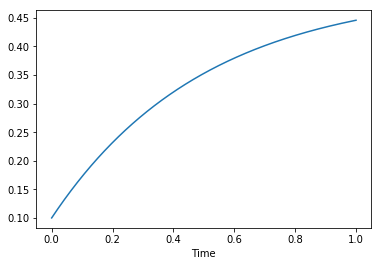

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as pl
from scipy.integrate import odeint

# Define the right-hand side of a system of ODEs
def r(y, t, p):
    k1 = p[0] # Forward reaction rate
    k2 = p[1] # Backward reaction rate
    dydt = (1 - y) * k1 - y * k2
    return dydt

# Run an example simulation:
p = [1, 1]    # parameters
y0 = 0.1      # initial conditions

# Call odeint, with the parameters wrapped in a tuple
times = np.linspace(0, 1, 1000)
values = odeint(r, y0, times, (p,))

# Reshape odeint's (1000x1) output to (1000,)
values = values.reshape((1000,))

# Plot the results
pl.figure()
pl.xlabel('Time')
pl.plot(times, values)
pl.show()

## A system of ODEs with a Pints wrapper

Now we'll wrap this code in something that extends the `pints.ForwardModel` class.

It should have two methods: one that runs simulations, and one that tells Pints what the dimension of the model's parameter vector is.

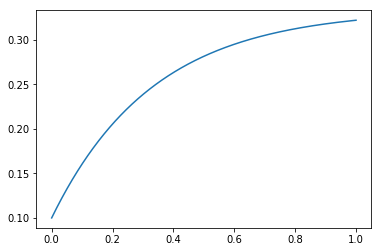

In [2]:
import pints

class ExampleModel(pints.ForwardModel):
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        y0 = 0.1
        def r(y, t, p):
            dydt = (1 - y) * p[0] - y * p[1]
            return dydt
        return odeint(r, y0, times, (parameters,)).reshape(times.shape)
    
    def dimension(self):
        # Return the dimension of the parameter vector
        return 2

# Create an instance of our new model class
model = ExampleModel()
    
# Run another example simulation
values = model.simulate([1,2], times)

# Plot the results
pl.figure()
pl.plot(times, values)
pl.show()

## An optimisation problem

Using this model, we can now set up an optimisation problem, and then solve it with Pints.

Running in parallel mode with population size 8
1: 0.654830032649
2: 0.654830032649
3: 0.654830032649
20: 0.489691303225
40: 0.402143512787
60: 0.399963734711
80: 0.399801832363
100: 0.399801135787
120: 0.399801133607
140: 0.399801133594
160: 0.399801133587
180: 0.399801133587
200: 0.399801133586
220: 0.399801133586
Halting: No significant change for 100 iterations.
237: 0.399801133586
Score at true solution:
0.400066882728
Found solution:          True parameters:
 5.02787159924509375e+00     5.00000000000000000e+00
 3.01671594074898453e+00     3.00000000000000000e+00


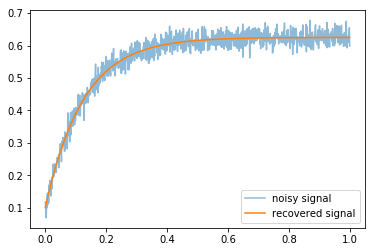

In [3]:
# Define the 'true' parameters
true_parameters = [5, 3]

# Run a simulation to get test data
values = model.simulate(true_parameters, times)

# Add some noise
values += np.random.normal(0, 0.02, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.Boundaries([0.1, 0.1], [10, 10])

# Perform an optimization
found_parameters, found_value = pints.snes(score, boundaries)

print('Score at true solution:')
print(score(true_parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))

# Plot the results
pl.figure()
pl.plot(times, values, alpha=0.5, label='noisy signal')
pl.plot(times, problem.evaluate(found_parameters), label='recovered signal')
pl.legend()
pl.show()